# QoE Modeling with User Tolerance

This notebook evaluates two models:
1. A traditional QoE prediction model based on success/failure (ITU-style)
2. An extended model incorporating user tolerance

We use F1-score and statistical tests (paired t-test, Wilcoxon) to compare the models.

In [1]:

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import f1_score
from scipy.stats import ttest_rel, wilcoxon

# Load data
df = pd.read_csv('../data/user_tolerance_responses.csv')

# Normalize QoE (0–10) to 0–5
df['QoE_norm'] = (df['QoE'] / 2).round().astype(int)

# Model 1: Sigmoid using SF only
def sigmoid_sf(sf, a, b, c):
    return a / (1 + np.exp(-b * (sf - c)))

sf = df['SF'].values
y = df['QoE_norm'].values
params_itu, _ = curve_fit(sigmoid_sf, sf, y, bounds=([1, 0.1, 0], [5, 10, 1]))
df['QoE_pred_ITU'] = sigmoid_sf(sf, *params_itu).round().astype(int)

# Model 2: Sigmoid using SF + Tolerance
def sigmoid_with_tolerance(sf, tol, a, b, c, d):
    base = a / (1 + np.exp(-b * (sf - c)))
    return np.clip(base + d * tol, 0, 5)

tolerance = df['Tolerance'].values
def fit_func(X, a, b, c, d):
    sf, tol = X
    return sigmoid_with_tolerance(sf, tol, a, b, c, d)

params_tol, _ = curve_fit(fit_func, (sf, tolerance), y, bounds=([1, 0.1, 0, -0.1], [5, 10, 1, 0.1]))
df['QoE_pred_TOL'] = sigmoid_with_tolerance(sf, tolerance, *params_tol).round().astype(int)

# F1-Scores
f1_itu_macro = f1_score(y, df['QoE_pred_ITU'], average='macro')
f1_itu_weighted = f1_score(y, df['QoE_pred_ITU'], average='weighted')
f1_tol_macro = f1_score(y, df['QoE_pred_TOL'], average='macro')
f1_tol_weighted = f1_score(y, df['QoE_pred_TOL'], average='weighted')

print("=== F1-Scores ===")
print(f"ITU Model           → Macro: {f1_itu_macro:.3f}, Weighted: {f1_itu_weighted:.3f}")
print(f"With Tolerance      → Macro: {f1_tol_macro:.3f}, Weighted: {f1_tol_weighted:.3f}")

# Accuracy comparison
correct_itu = (df['QoE_norm'] == df['QoE_pred_ITU']).astype(int)
correct_tol = (df['QoE_norm'] == df['QoE_pred_TOL']).astype(int)

# Statistical Tests
t_stat, p_t = ttest_rel(correct_tol, correct_itu)
w_stat, p_w = wilcoxon(correct_tol, correct_itu)

print("\n=== Statistical Tests ===")
print(f"Paired t-test       → t = {t_stat:.3f}, p = {p_t:.3f}")
print(f"Wilcoxon test       → W = {w_stat:.3f}, p = {p_w:.3f}")

# Show fitted parameters
print("\n=== Model Parameters ===")
print("ITU Model           → a = {:.3f}, b = {:.3f}, c = {:.3f}".format(*params_itu))
print("With Tolerance      → a = {:.3f}, b = {:.3f}, c = {:.3f}, d = {:.3f}".format(*params_tol))


=== F1-Scores ===
ITU Model           → Macro: 0.167, Weighted: 0.273
With Tolerance      → Macro: 0.341, Weighted: 0.407

=== Statistical Tests ===
Paired t-test       → t = 1.879, p = 0.061
Wilcoxon test       → W = 598.500, p = 0.061

=== Model Parameters ===
ITU Model           → a = 4.601, b = 2.742, c = 0.060
With Tolerance      → a = 4.690, b = 1.645, c = 0.044, d = 0.100


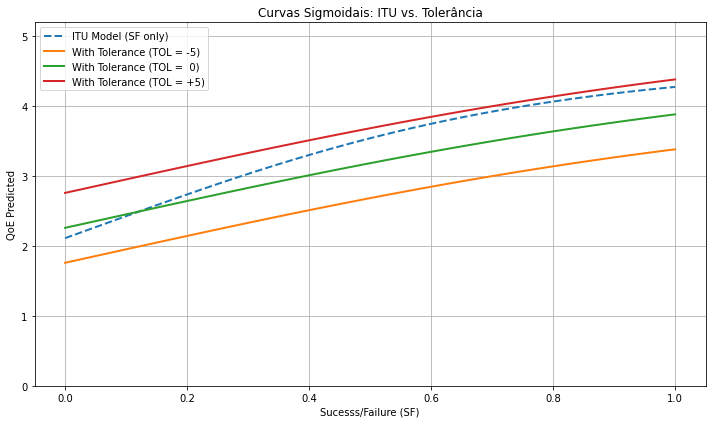

In [2]:
import matplotlib.pyplot as plt

# Valores de SF de 0 a 1 com resolução fina
sf_range = np.linspace(0, 1, 100)

# Curva do modelo ITU
itu_curve = sigmoid_sf(sf_range, *params_itu)

# Curvas do modelo com Tolerância para diferentes níveis
tol_curves = {
    'TOL = -5': sigmoid_with_tolerance(sf_range, -5, *params_tol),
    'TOL =  0': sigmoid_with_tolerance(sf_range, 0, *params_tol),
    'TOL = +5': sigmoid_with_tolerance(sf_range, 5, *params_tol),
}

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sf_range, itu_curve, label="ITU Model (SF only)", linewidth=2, linestyle='--')

for label, curve in tol_curves.items():
    plt.plot(sf_range, curve, label=f"With Tolerance ({label})", linewidth=2)

plt.title("Curvas Sigmoidais: ITU vs. Tolerância")
plt.xlabel("Sucesss/Failure (SF)")
plt.ylabel("QoE Predicted")
plt.legend()
plt.grid(True)
plt.ylim(0, 5.2)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Carregar os dados
df = pd.read_csv("../data/user_tolerance_responses.csv")

# Normalizar a QoE (0–10) para escala 0–5
df['QoE_norm'] = (df['QoE'] / 2).round().astype(int)

# Modelo ITU (apenas SF)
def sigmoid_sf(sf, a, b, c):
    return a / (1 + np.exp(-b * (sf - c)))

params_itu = [4.601, 2.742, 0.060]
df['QoE_pred_ITU'] = sigmoid_sf(df['SF'].values, *params_itu).round().astype(int)

# Modelo com Tolerância
def sigmoid_with_tolerance(sf, tol, a, b, c, d):
    base = a / (1 + np.exp(-b * (sf - c)))
    return np.clip(base + d * tol, 0, 5)

params_tol = [4.690, 1.645, 0.044, 0.100]
df['QoE_pred_TOL'] = sigmoid_with_tolerance(df['SF'].values, df['Tolerance'].values, *params_tol).round().astype(int)

pd.set_option('display.max_rows', None)  # Exibir todas as linhas
pd.set_option('display.max_columns', None)  # Exibir todas as colunas
df


,QoE,Tolerance,SF,QoE_norm,QoE_pred_ITU,QoE_pred_TOL
0,9,9,1,4,4,5
1,9,10,1,4,4,5
2,10,6,1,5,4,4
3,10,10,1,5,4,5
4,10,8,1,5,4,5
5,9,9,1,4,4,5
6,7,-2,1,4,4,4
7,9,2,1,4,4,4
8,7,2,1,4,4,4
9,8,10,1,4,4,5
